In [33]:
import sys
sys.path.insert(1, '/cis/home/adesilva/ashwin/research/ood-tl')

from datahandlers.pacs import PACSHandler

import numpy as np
import omegaconf
from imshowtools import imshow
from PIL import Image
from copy import deepcopy

from sklearn.metrics import pairwise_kernels, pairwise_distances
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torchvision
from torch.cuda.amp import autocast

import contextlib
import joblib
from joblib import Parallel, delayed
from tqdm import tqdm
import itertools
from itertools import product
import matplotlib.pyplot as plt

In [91]:
def set_seed(seed=0):
    """
    Don't set true seed to be nearby values. Doesn't give best randomness
    """
    rng = np.random.default_rng(seed)
    true_seed = int(rng.integers(2**30))

    np.random.seed(true_seed)
    np.random.seed(true_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(true_seed)
    torch.cuda.manual_seed_all(true_seed)

set_seed(1996)

In [35]:
# misc functions

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()


def visualize_samples(loader, idx):
    samples = []
    path_list = loader.dataset.data[idx]
    for path in path_list:
        im = np.asarray(Image.open(path[0]))
        samples.append(im)
    samples = np.array(samples)
    imshow(*samples)

In [36]:
# Kernel two-sample test functions

def MMD2u(K, m, n):
    """The MMD^2_u unbiased statistic.
    """
    Kx = K[:m, :m]
    Ky = K[m:, m:]
    Kxy = K[:m, m:]
    return 1.0 / (m * (m - 1.0)) * (Kx.sum() - Kx.diagonal().sum()) + \
        1.0 / (n * (n - 1.0)) * (Ky.sum() - Ky.diagonal().sum()) - \
        2.0 / (m * n) * Kxy.sum()


def compute_null_distribution(K, m, n, iterations=10000, verbose=False,
                              random_state=None, marker_interval=1000):
    """Compute the bootstrap null-distribution of MMD2u.
    """
    if type(random_state) == type(np.random.RandomState()):
        rng = random_state
    else:
        rng = np.random.RandomState(random_state)

    mmd2u_null = np.zeros(iterations)
    for i in range(iterations):
        if verbose and (i % marker_interval) == 0:
            print(i),
            stdout.flush()
        idx = rng.permutation(m+n)
        K_i = K[idx, idx[:, None]]
        mmd2u_null[i] = MMD2u(K_i, m, n)

    if verbose:
        print("")

    return mmd2u_null


def compute_null_distribution_given_permutations(K, m, n, permutation,
                                                 iterations=None):
    """Compute the bootstrap null-distribution of MMD2u given
    predefined permutations.
    Note:: verbosity is removed to improve speed.
    """
    if iterations is None:
        iterations = len(permutation)

    mmd2u_null = np.zeros(iterations)
    for i in range(iterations):
        idx = permutation[i]
        K_i = K[idx, idx[:, None]]
        mmd2u_null[i] = MMD2u(K_i, m, n)

    return mmd2u_null


def kernel_two_sample_test(X, Y, kernel_function='rbf', iterations=10000,
                           verbose=False, random_state=None, **kwargs):
    """Compute MMD^2_u, its null distribution and the p-value of the
    kernel two-sample test.
    Note that extra parameters captured by **kwargs will be passed to
    pairwise_kernels() as kernel parameters. E.g. if
    kernel_two_sample_test(..., kernel_function='rbf', gamma=0.1),
    then this will result in getting the kernel through
    kernel_function(metric='rbf', gamma=0.1).
    """
    m = len(X)
    n = len(Y)
    XY = np.vstack([X, Y])
    K = pairwise_kernels(XY, metric=kernel_function, **kwargs)
    mmd2u = MMD2u(K, m, n)
    if verbose:
        print("MMD^2_u = %s" % mmd2u)
        print("Computing the null distribution.")

    mmd2u_null = compute_null_distribution(K, m, n, iterations,
                                           verbose=verbose,
                                           random_state=random_state)
    p_value = max(1.0/iterations, (mmd2u_null > mmd2u).sum() /
                  float(iterations))
    if verbose:
        print("p-value ~= %s \t (resolution : %s)" % (p_value, 1.0/iterations))

    return mmd2u, mmd2u_null, p_value

In [37]:
# get feature matrix from pretrained model
def get_feature_mat(model, loader, num_features, gpu=1):
    device = torch.device("cuda:{}".format(gpu))
    model.to(device)
    model.eval()
    feature_mat = torch.zeros((len(loader.dataset), num_features))
    class_labs = torch.zeros(len(loader.dataset))
    with torch.no_grad():
        for ims, targets, ids in loader:
            ims = ims.to(device)
            _ , labs = targets
            labs = labs.to(device)
            with autocast():
                out = model(ims)
                feature_mat[ids.squeeze(-1)] = out.squeeze().float().cpu()
                class_labs[ids.squeeze(-1)] = labs.squeeze().float().cpu()
    return feature_mat, class_labs

# define the iteration
def iteration(D_1, num_samples_per_iter, sig_level=0.05):
    idx = np.random.choice(len(D_1), 2 * num_samples_per_iter, replace=False)
    idxA = idx[:num_samples_per_iter]
    idxB = idx[num_samples_per_iter:]
    A = D_1[idxA]
    B = D_1[idxB]
    sigma2 = np.median(pairwise_distances(A, B, metric='euclidean'))**2
    t, _ , p_value =  kernel_two_sample_test(A, B, kernel_function='rbf', gamma=1.0/sigma2)
    weights = np.zeros((len(D_1), len(D_1)))
    prod = list(product(idxA, idxB))
    if p_value < sig_level:
        for x in prod:
            weights[x[0], x[1]] = t / num_samples_per_iter
    return weights

In [71]:
# set params

# dataset params
n0 = 30
n1 = 10
m_n = 2
ood_fraction = 1/6

# OOD detection params
num_samples_per_iter = 14
max_iter = 3000

# other
seed = 10
batchsize = 16

In [72]:
cfg = omegaconf.OmegaConf.load("/cis/home/adesilva/ashwin/research/ood-tl/config/conf.yaml")
cfg.task.target_env = 'P'       # number of total samples in the dataset: 590 (147 + 443)
cfg.task.ood_env = 'S'          # number of total samples in the dataset: 2328
cfg.task.task_map = [[0,1,4]]
cfg.task.n = n1
cfg.task.m_n = m_n
cfg.hp.bs = batchsize
dataHandler = PACSHandler(cfg)
dataHandler.sample_data(seed)

loader = dataHandler.get_data_loader(train=True)  # comprises of target data and a known fraction of OOD data

In [73]:
# Obtain the featurizer from the pre-trained ResNet-18 model
ptmodel = torchvision.models.resnet18(pretrained=True)
num_features = ptmodel.fc.in_features
for param in ptmodel.parameters():
    param.requires_grad = False
featurizer = nn.Sequential(*list(ptmodel.children())[:-1])

In [74]:
# Obtain the feature matrices
feature_mat, _ = get_feature_mat(featurizer, loader, num_features)

In [75]:
# compute the weights for each iteration
f = lambda : iteration(feature_mat, num_samples_per_iter)

with tqdm_joblib(tqdm(desc="Running iterations...", total=max_iter, position=0, leave=True)) as progress_bar:
    all_weights = np.array(Parallel(n_jobs=-1)(delayed(f)() for i in range(max_iter)))

Running iterations...: 100%|██████████| 3000/3000 [01:29<00:00, 33.58it/s]


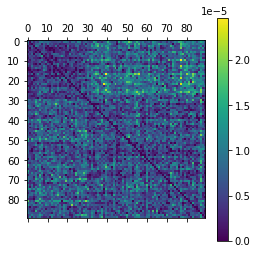

In [78]:
# get the mean pairwise weight matrix and visualize it
mean_pairwise_weights = np.mean(all_weights, axis=0)
plt.matshow(mean_pairwise_weights)
plt.colorbar()

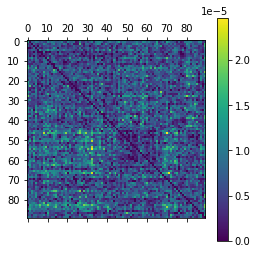

In [83]:
clustering = AgglomerativeClustering(n_clusters=2, metric='precomputed', linkage='complete', compute_distances=True).fit(mean_pairwise_weights)
cluster_assignments = clustering.labels_

# sort the samples according to the cluster assignments and visualize
ordered_assignments = np.argsort(cluster_assignments)
ordered_pairwise_weights = mean_pairwise_weights[:, ordered_assignments][ordered_assignments]
plt.matshow(ordered_pairwise_weights)
plt.colorbar()

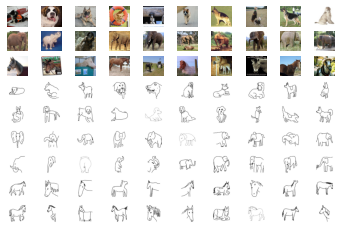

In [84]:
# visualize all samples 
visualize_samples(loader, np.arange(len(feature_mat)))

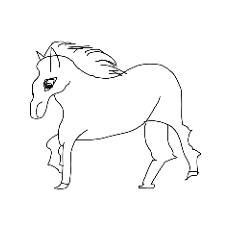

In [86]:
# visualize the separated OOD samples
predicted_ood_idx = np.where(cluster_assignments == 1)[0]
visualize_samples(loader, predicted_ood_idx)

### Evaluating the Performance of the Data Purification Algorithm

In [112]:
def get_metrics(result):
    """Return recall, precision, false positive rate, false negative rate, f1-score, and accuracy"""
    tn, fp, fn, tp = result 
    recall = tp / (tp + fn)
    precision = tn / (tn + fp)
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    f1 = 2 * tp / (2 * tp + fp + fn)
    acc = (tp + tn) / (tp + tn + fp + fn)
    return recall, precision, fpr, fnr, f1, acc

In [121]:
# set params

# dataset params
n = 10
m_n_list = [0.4, 0.8, 1.2, 1.6, 2.0]

# OOD detection params
num_samples_per_iter = 10
max_iter = 1000

# other
seed = 10
num_reps = 3
batchsize = 16

In [122]:
cfg = omegaconf.OmegaConf.load("/cis/home/adesilva/ashwin/research/ood-tl/config/conf.yaml")
cfg.task.target_env = 'P'       # number of total samples in the dataset: 590 (147 + 443)
cfg.task.ood_env = 'S'          # number of total samples in the dataset: 2328
cfg.task.task_map = [[0,1,4]]
cfg.task.n = n
cfg.hp.bs = batchsize
num_classes = len(cfg.task.task_map[0])

In [123]:
# Obtain the featurizer from the pre-trained ResNet-18 model
ptmodel = torchvision.models.resnet18(pretrained=True)
num_features = ptmodel.fc.in_features
for param in ptmodel.parameters():
    param.requires_grad = False
featurizer = nn.Sequential(*list(ptmodel.children())[:-1])

In [124]:
set_seed(1996)

results = []
pred_labels = []

for i, m_n in enumerate(m_n_list):
    if m_n < 1:
        num_samples_per_iter = int(n * m_n * num_classes + 2) # adaptive num samples per iter
    else:
        num_samples_per_iter = int(n * num_classes + 2) # adaptive num samples per iter

    for rep in range(num_reps):
        cfg.task.m_n = m_n
        dataHandler = PACSHandler(cfg)

        dataHandler.sample_data(seed + 10*rep)
        loader = dataHandler.get_data_loader(train=True)  # comprises of target data and a known fraction of OOD data

        # Obtain the feature matrices
        feature_mat, _ = get_feature_mat(featurizer, loader, num_features)

        # compute the weights for each iteration
        f = lambda : iteration(feature_mat, num_samples_per_iter)

        with tqdm_joblib(tqdm(desc="Running iterations...", total=max_iter, position=0, leave=True)) as progress_bar:
            all_weights = np.array(Parallel(n_jobs=-1)(delayed(f)() for i in range(max_iter)))

        mean_pairwise_weights = np.mean(all_weights, axis=0)

        clustering = AgglomerativeClustering(n_clusters=2, metric='precomputed', linkage='complete', compute_distances=True).fit(mean_pairwise_weights)
        cluster_assignments = clustering.labels_

        # select the appropriate cluster as OOD given the target/OOD ratio
        if m_n < 1:
            if np.sum(cluster_assignments) > 0.5 * len(cluster_assignments):
                cluster_assignments = abs(cluster_assignments - 1)
        else:
            if np.sum(cluster_assignments) < 0.5 * len(cluster_assignments):
                cluster_assignments = abs(cluster_assignments - 1)

        # true labels
        task_labels = np.array(loader.dataset.targets)[:, 0]

        # compute metrics
        result = [m_n, rep, confusion_matrix(task_labels, cluster_assignments).ravel()]
        results.append(result)

        pred_labels.append([m_n, rep, cluster_assignments])

results = np.array(results)
pred_labels = np.array(pred_labels)

Running iterations...: 100%|██████████| 1000/1000 [00:48<00:00, 20.82it/s]
/tmp/ipykernel_8836/1735698451.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results = np.array(results)
/tmp/ipykernel_8836/1735698451.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred_labels = np.array(pred_labels)


In [127]:
metrics = []
for result in results:
    metrics.append([result[0], result[1], np.array(get_metrics(result[-1]))])
metrics = np.array(metrics)

avg_metrics = []
std_metrics = []
for m_n in m_n_list:
    avg_metrics.append(np.mean(metrics[metrics[:, 0] == m_n][:, 2]))
    std_metrics.append(np.std(metrics[metrics[:, 0] == m_n][:, 2]))
avg_metrics = np.array(avg_metrics)
std_metrics = np.array(std_metrics)

/tmp/ipykernel_8836/1819787674.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  metrics = np.array(metrics)


Text(0.5, 0.98, 'Data Purification Performance')

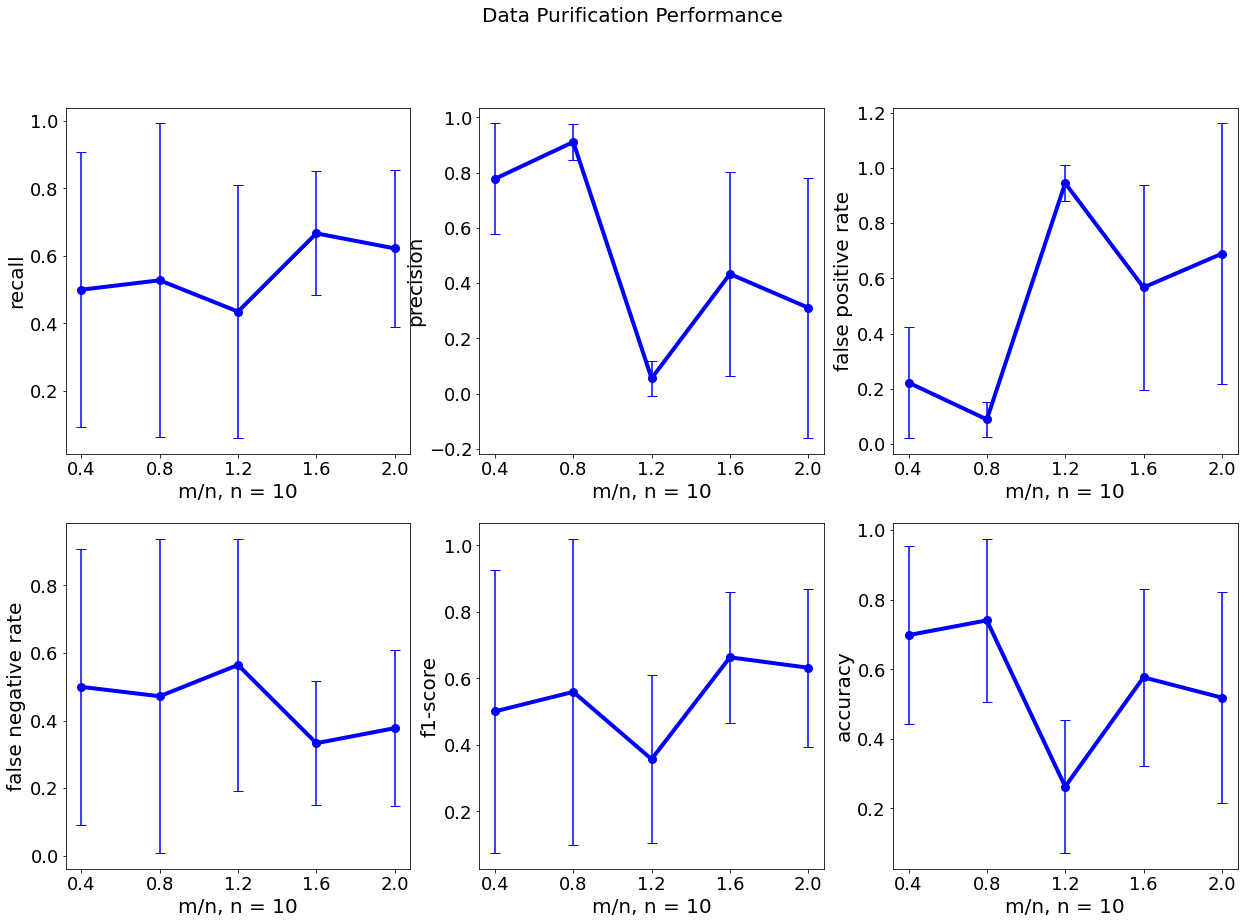

In [128]:
fontsize = 20
labelsize = 18
lw = 4
s = 8

metric_names = ['recall', 'precision', 'false positive rate', 'false negative rate', 'f1-score', 'accuracy']

fig, axes = plt.subplots(2, 3, figsize=(21, 14))

for i, name in enumerate(metric_names):
    ax = axes.ravel()[i]
    ci = 1.96 * std_metrics[:, i] / np.sqrt(num_reps)
    ax.plot(m_n_list, avg_metrics[:, i], lw=lw, marker='o', markersize=s, color='b')
    ax.errorbar(m_n_list, avg_metrics[:, i], yerr=ci, solid_capstyle='projecting', capsize=5, color='b')
    ax.tick_params(axis='x', labelsize=labelsize)
    ax.tick_params(axis='y', labelsize=labelsize)

    ax.set_ylabel(name, fontsize=fontsize)    
    ax.set_xlabel("m/n, n = {}".format(n), fontsize=fontsize)

    ax.set_xticks(m_n_list)

fig.suptitle("Data Purification Performance", fontsize=fontsize)

In [171]:
# # save metrics
# np.save("data_purification_performance.npy", metrics) # to read data use : np.load("data_purification_performance.npy", allow_pickle=True)

### Effect of Dataset Purification on Model Performance

In [2]:
import wandb

In [ ]:
api = wandb.Api()
runs = api.runs("ashwin1996/data_purification")
tag = "2evf3xn9"

for run in runs: 
    try:
        run_tag = run.name
    except KeyError:
        run_tag = "None"
    if run_tag == tag:
        avg_errs = np.array(run.summary['avg_err'])
        std_errs = np.array(run.summary['std_err']) 
        avg_mets = np.array(run.summary['avg_mets'])
        std_mets = np.array(run.summary['std_mets'])

Text(0.5, 1.0, 'Performance of Data Purification Algorithm')

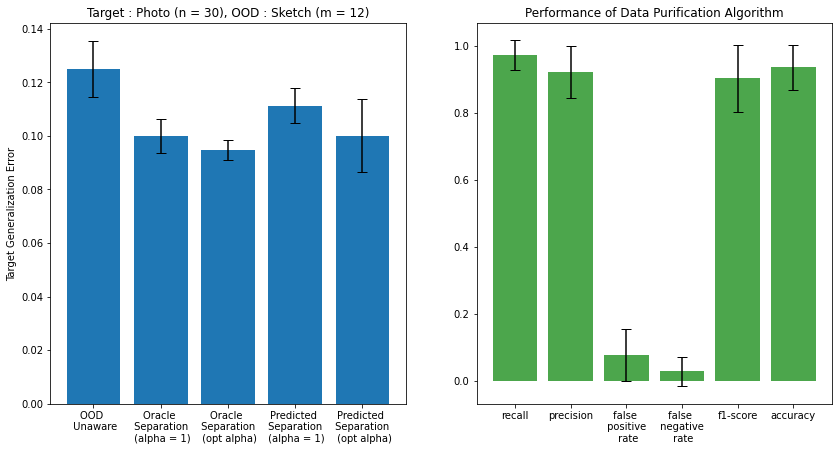

In [32]:
fontsize = 20
labelsize = 18
lw = 4
s = 8

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

setups = ["OOD \n Unaware", "Oracle \n Separation \n (alpha = 1)", 
          "Oracle \n Separation \n (opt alpha)", "Predicted \n Separation \n (alpha = 1)", "Predicted \n Separation \n (opt alpha)"]
# setups = ["No \n Purification \n OOD Unaware", 
#           "No \n Purification \n OOD Aware \n (Optimal)", "Purification \n OOD Aware \n (Optimal)"]
xpos = np.arange(len(setups))
ax = axes[0]
ax.bar(xpos, avg_errs, yerr=1.96 * std_errs / np.sqrt(3), align='center', capsize=5)
ax.set_xticks(xpos)
ax.set_xticklabels(setups)
ax.set_ylabel('Target Generalization Error')
ax.set_title("Target : Photo (n = 30), OOD : Sketch (m = 12)")

metric_names = ['recall', 'precision', 'false \n positive \n rate', 'false \n negative \n rate', 'f1-score', 'accuracy']
xpos = np.arange(len(metric_names))
ax = axes[1]
ax.bar(xpos, avg_mets, yerr=1.96 * std_mets / np.sqrt(3), align='center', capsize=5, color='g', alpha=0.7)
ax.set_xticks(xpos)
ax.set_xticklabels(metric_names)
ax.set_title("Performance of Data Purification Algorithm")


### Plots

In [129]:
import wandb

In [148]:
api = wandb.Api()
runs = api.runs("ashwin1996/data_purification")
tag = "01_data_purification/exp4"

m_n = []
avg_error = []
std_error = []
for run in runs: 
    try:
        run_tag = run.config['tag']
    except KeyError:
        run_tag = "None"
    if run_tag == tag:
        m_n.append(run.config['task']['m_n'])
        avg_error.append(run.summary['avg_err'])
        std_error.append(run.summary['std_err'])
idx = np.argsort(m_n)
m_n = np.array(m_n)[idx]
avg_error = np.array(avg_error)[idx]
std_error = np.array(std_error)[idx]

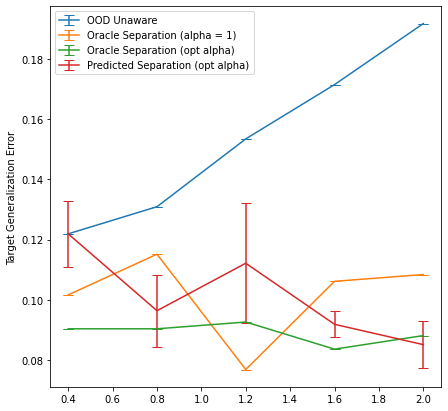

In [155]:
fontsize = 20
labelsize = 18
lw = 4
s = 8

fig, ax = plt.subplots(figsize=(7, 7))

setups = ["OOD Unaware", "Oracle Separation (alpha = 1)", 
          "Oracle Separation (opt alpha)", "Predicted Separation (opt alpha)"]

for i in range(4):
    # ax.plot(m_n, avg_error[:, i])
    ax.errorbar(m_n, avg_error[:, i], yerr=std_error[:, i]*1.96/np.sqrt(3), solid_capstyle='projecting', capsize=5)
ax.set_ylabel('Target Generalization Error')
ax.legend(setups)
